In [15]:
import numpy as np
import pandas as pd
import scipy 
import numpy.matlib
import nilearn
import random
import matplotlib.pyplot as plt
import seaborn as sns
import glob
# import matplotlib_inline
import matplotlib
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [30]:
# motor and value areas functional connectivity matrix
task_fc = pd.read_csv('task_fc_motor_value.csv', index_col = 'Subject')
X = task_fc

In [31]:
Y = pd.read_csv('../data/aggregate_indices_subs101_148_08Dec2020.csv', index_col = 'Subject')
Y = Y.rename({'AFRIAT Index' : 'Afriat Index', 'VARIAN Index AVG(SSQ)' : 'Varian Index', 'MMI Criterion Avg(SumOfSquares(Wastes))' : 'MMI'}, axis = 1)


<AxesSubplot:>

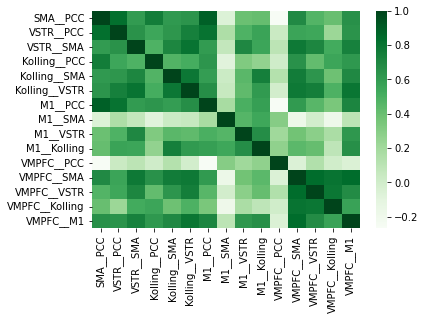

In [14]:
sns.heatmap(X.corr(), cmap='Greens')

In [33]:
XY_merged = pd.concat([Y, X], axis=1)

In [ ]:
covariates = '+'.join(X.columns.to_list())

In [45]:
lm = smf.ols(f'MMI ~ {covariates}', XY_merged)

In [46]:
lm_fit = lm.fit_regularized(alpha=0.1, L1_wt=1)

In [48]:
lm_fit.summary()

NotImplementedError: 

In [4]:
# read trial by trial data and merge into one dataframe
data_dir = r'./trial_data/'
behavioral_files = glob.glob(data_dir+'*')
behavioral_results = [pd.read_excel(behavioral_files[i]) for i in range(len(behavioral_files))]
behavioral_results = pd.concat(behavioral_results)

In [8]:
pd.options.display.max_columns=100

In [11]:
Y = behavioral_results.groupby(['SID', 'block']).mean()


In [17]:
Y = Y.rename({'MMI_In_Sample_component' : 'MMI'})